In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys

In [2]:
import random
import numpy as np
import torch
import os

def set_global_seed(seed=42):
    """Set seed for reproducibility across NumPy, PyTorch, and OS operations."""
    
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using CUDA
    
    # Ensure deterministic behavior in PyTorch (optional, can slow training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for other libraries
    os.environ["PYTHONHASHSEED"] = str(seed)

# Set global seed
set_global_seed(42)

In [3]:
test_data_X = pd.read_csv(r"C:\Users\TESTER\OneDrive\Ambiente de Trabalho\Thesis Folder\Data After Preprocess\processed_test_data_X_data.csv")
train_data_X = pd.read_csv(r"C:\Users\TESTER\OneDrive\Ambiente de Trabalho\Thesis Folder\Data After Preprocess\processed_train_data_X_data.csv")
test_labels_encoded = pd.read_csv(r"C:\Users\TESTER\OneDrive\Ambiente de Trabalho\Thesis Folder\Data After Preprocess\processed_test_data_y_data.csv")
train_labels_encoded = pd.read_csv(r"C:\Users\TESTER\OneDrive\Ambiente de Trabalho\Thesis Folder\Data After Preprocess\processed_train_data_y_data.csv")

In [4]:
train_data_y_binary = train_labels_encoded["label"]
test_data_y_binary = test_labels_encoded["label"]

In [5]:
test_data_y = test_labels_encoded["attack_cat"]

In [6]:
train_data_y = train_labels_encoded["attack_cat"]

In [7]:
train_data_y.value_counts()

attack_cat
6    56000
5    40000
3    33393
4    18184
2    12264
7    10491
0     2000
1     1746
8     1133
9      130
Name: count, dtype: int64

# Modelling

In [8]:
train_data_X.shape

(175341, 56)

In [ ]:

from sklearn.feature_selection import SelectKBest, f_classif

# Select the top 40 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=45)
X_selected = selector.fit_transform(train_data_X, train_labels_encoded["label"])

# Get the selected feature names
selected_features = train_data_X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())


Selected Features: ['encoder__proto_arp', 'encoder__proto_ospf', 'encoder__proto_tcp', 'encoder__proto_udp', 'encoder__proto_unas', 'encoder__service_dns', 'encoder__service_ftp-data', 'encoder__state_CON', 'encoder__state_FIN', 'encoder__state_INT', 'remainder__dur', 'remainder__spkts', 'remainder__dpkts', 'remainder__sbytes', 'remainder__dbytes', 'remainder__rate', 'remainder__sttl', 'remainder__dttl', 'remainder__sload', 'remainder__dload', 'remainder__sloss', 'remainder__dloss', 'remainder__sinpkt', 'remainder__dinpkt', 'remainder__sjit', 'remainder__djit', 'remainder__swin', 'remainder__stcpb', 'remainder__dtcpb', 'remainder__dwin', 'remainder__tcprtt', 'remainder__synack', 'remainder__ackdat', 'remainder__dmean', 'remainder__ct_state_ttl', 'remainder__ct_dst_ltm', 'remainder__ct_src_dport_ltm', 'remainder__ct_dst_sport_ltm', 'remainder__ct_srv_dst', 'remainder__is_sm_ips_ports']


## Modelling EfficentKan

In [10]:
#train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
#test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze() #changed to have all features

train_X_tensor = torch.tensor(train_data_X[selected_features].values, dtype=torch.float32).squeeze()
test_X_tensor = torch.tensor(test_data_X[selected_features].values, dtype=torch.float32).squeeze()

train_Y_tensor = torch.tensor(train_data_y.values, dtype=torch.long).squeeze()

test_Y_tensor = torch.tensor(test_data_y.values, dtype=torch.long).squeeze()
#a dictionary with the 4 datasets

In [11]:
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [12]:
# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Modelling with efficient Kan

In [14]:
from efficient_kan import KAN

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define model
model = KAN([40, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()

In [16]:
model.grid_size, model.spline_order

(5, 3)

In [17]:
from sklearn.model_selection import KFold

In [21]:
model = KAN([40, 20,10, 5,10],grid_size = 6, spline_order = 3, scale_noise=0.2, scale_base=0.2, scale_spline=0.2) #best

In [22]:
from sklearn.metrics import f1_score
loss_over_train = []
loss_over_test = []
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    epoch_loss = 0
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


        
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        
    mean_loss = epoch_loss / len(dataloader) 
    loss_over_train.append(mean_loss)

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    mean_loss = test_loss / num_batches  # Divide by the number of batches
    loss_over_test.append(mean_loss)

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance
    f1_macro = f1_score(all_labels, all_preds, average='macro') * 100  # Macro F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}%, Macro_F1-Score: {f1_macro: .2f}%  \n")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Number of folds
k_folds = 5
epochs = 200  # Number of training epochs per fold
batch_size = 32  # Adjust batch size as needed

# Define K-Fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define loss function and learning parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-4

# Combine datasets (Only Train Data)
dataset = train_dataset  # Use only training dataset

# Store results across folds
fold_accuracies = []
fold_f1_scores = []
fold_f1_macro_scores = []
fold_losses = []

# K-Fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"\nFold {fold + 1}/{k_folds}\n" + "-" * 30)
    print("initializing model...")
    model = KAN([45, 20,10, 5,10],grid_size = 6, spline_order = 3, scale_noise=0.2, scale_base=0.2, scale_spline=0.2) #best
    # Create data subsets for the current fold
    train_subset = Subset(dataset, train_ids)
    val_subset = Subset(dataset, val_ids)

    # Create data loaders for the current fold
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Re-initialize model and optimizer for each fold
     # Replace with your model class
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training function
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        correct, total = 0, 0
        epoch_loss = 0

        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()

            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

        return correct / total * 100, epoch_loss / len(dataloader)

    # Validation function
    def val_loop(dataloader, model, loss_fn):
        model.eval()
        correct, total = 0, 0
        val_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                val_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                all_preds.extend(pred.argmax(1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        accuracy = correct / len(dataloader.dataset) * 100
        f1 = f1_score(all_labels, all_preds, average='weighted') * 100
        f1_macro = f1_score(all_labels, all_preds, average='macro') * 100
        mean_loss = val_loss / len(dataloader)

        return accuracy, f1, f1_macro, mean_loss

    # Train and validate for this fold
    for epoch in range(epochs):
        train_acc, train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        val_acc, f1, f1_macro, val_loss = val_loop(val_dataloader, model, loss_fn)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, F1={f1:.2f}%, Macro F1={f1_macro:.2f}%")

    # Store fold results
    fold_accuracies.append(val_acc)
    fold_f1_scores.append(f1)
    fold_f1_macro_scores.append(f1_macro)
    fold_losses.append(val_loss)

# Print final results
print("\nCross-Validation Results:")
print(f"Avg Validation Accuracy: {sum(fold_accuracies) / k_folds:.2f}%")
print(f"Avg Weighted F1-score: {sum(fold_f1_scores) / k_folds:.2f}%")
print(f"Avg Macro F1-score: {sum(fold_f1_macro_scores) / k_folds:.2f}%")
print(f"Avg Validation Loss: {sum(fold_losses) / k_folds:.6f}")



Fold 1/5
------------------------------
Epoch 1: Train Acc=66.52%, Val Acc=73.18%, F1=67.95%, Macro F1=29.75%
Epoch 2: Train Acc=74.72%, Val Acc=75.57%, F1=72.52%, Macro F1=35.35%
Epoch 3: Train Acc=75.93%, Val Acc=77.09%, F1=74.26%, Macro F1=37.69%
Epoch 4: Train Acc=77.10%, Val Acc=76.99%, F1=74.40%, Macro F1=37.91%
Epoch 5: Train Acc=77.28%, Val Acc=77.13%, F1=74.43%, Macro F1=37.92%
Epoch 6: Train Acc=77.54%, Val Acc=77.94%, F1=75.02%, Macro F1=38.50%
Epoch 7: Train Acc=77.79%, Val Acc=77.84%, F1=75.01%, Macro F1=38.63%
Epoch 8: Train Acc=78.00%, Val Acc=78.17%, F1=75.20%, Macro F1=38.73%
Epoch 9: Train Acc=78.21%, Val Acc=78.40%, F1=75.33%, Macro F1=38.83%
Epoch 10: Train Acc=78.24%, Val Acc=78.31%, F1=75.41%, Macro F1=39.04%


In [ ]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn = FocalLoss(alpha=0.5, gamma = 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4) #using L2 regularization

epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!") #wider network

Epoch 1
-------------------------------
loss: 2.260435  [    0/175341]
loss: 2.178968  [ 1600/175341]
loss: 2.091363  [ 3200/175341]
loss: 1.759666  [ 4800/175341]
loss: 2.150178  [ 6400/175341]
loss: 1.818884  [ 8000/175341]
loss: 1.956686  [ 9600/175341]
loss: 1.439500  [11200/175341]
loss: 1.694268  [12800/175341]
loss: 1.211658  [14400/175341]
loss: 1.299304  [16000/175341]
loss: 1.116312  [17600/175341]
loss: 1.090212  [19200/175341]
loss: 1.289851  [20800/175341]
loss: 1.368616  [22400/175341]
loss: 0.811075  [24000/175341]
loss: 0.847782  [25600/175341]
loss: 0.809049  [27200/175341]
loss: 0.681475  [28800/175341]
loss: 1.096894  [30400/175341]
loss: 1.002019  [32000/175341]
loss: 1.114056  [33600/175341]
loss: 0.635750  [35200/175341]
loss: 0.955600  [36800/175341]
loss: 0.825421  [38400/175341]
loss: 0.653893  [40000/175341]
loss: 0.807320  [41600/175341]
loss: 0.788785  [43200/175341]
loss: 0.911538  [44800/175341]
loss: 0.951580  [46400/175341]
loss: 0.479551  [48000/175341]

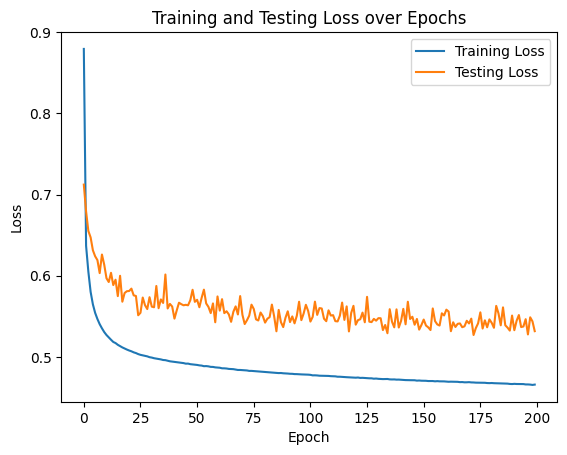

In [ ]:
#noise scale is low (0.2)
plt.plot(loss_over_train, label="Training Loss")
plt.plot(loss_over_test, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

# Confusion Matrix

In [ ]:
import pickle
import pandas as pd

# Load the LabelEncoder object from the file
with open(r"C:\Users\TESTER\OneDrive\Ambiente de Trabalho\Thesis Folder\Data After Preprocess\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


# Now you can use the label_encoder object in the second notebook
original_class_labels = label_encoder.classes_

c:\Users\TESTER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
original_labels_test = label_encoder.inverse_transform(test_data_y.values.flatten())

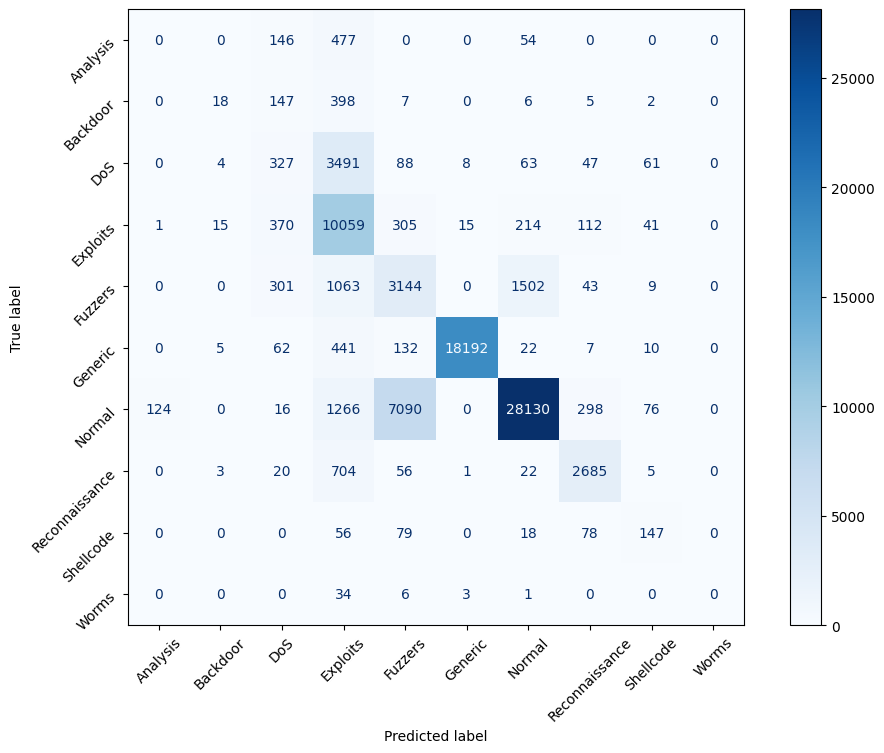

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(test_X_tensor)  # Forward pass
    y_pred = torch.argmax(y_pred, dim=1)  # Get class predictions

# Convert tensors to NumPy arrays for sklearn
y_pred = y_pred.cpu().numpy()
y_true = test_Y_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

fig, ax = plt.subplots(figsize=(12, 8))  #Creates both a figure and an ax

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Rotate axis labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
import torch.nn.functional as F

with torch.no_grad():
    y_score = F.softmax(model(test_X_tensor), dim=1)

In [ ]:
np.average(y_score.numpy())

0.1

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_data_y)
y_onehot_test = label_binarizer.transform(test_labels_encoded)
y_onehot_test.shape  # (n_samples, n_classes)

ValueError: Multioutput target data is not supported with label binarization

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

## Feature Selection using ANOVA F-test

In [ ]:

from sklearn.feature_selection import SelectKBest, f_classif

# Select the top 40 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=40)
X_selected = selector.fit_transform(train_data_X, train_labels_encoded["label"])

# Get the selected feature names
selected_features = train_data_X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())
